Evaulate the time gaps between two filters

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [4]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.4/"  # path to all opsim databases

# output directory
outDir = 'outDir'
resultsDb = db.ResultsDb(outDir=outDir)


In [209]:
class filterPairTimeMetric(metrics.BaseMetric):
    """
    returns all observation visits between two filters
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                 filename='dT.pkl', fltpair=['y','i'],
                 dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.dataout = dataout
                
        self.Nrun = 0
        if os.path.isfile(filename):
            # rm old file
            os.system("rm {}".format(filename))
        
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)

#    def dT(self, dataSlice, f0='i', f1='r'):
#        ''' return an array that contains all time gaps between two filters'''
#        idx0 = dataSlice['filter'] == f0
#        idx1 = dataSlice['filter'] == f1
#        
#        timeCol0 = dataSlice['observationStartMJD'][idx0]
#        timeCol1 = dataSlice['observationStartMJD'][idx1]
#
#        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
#        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        #diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) )

        #return diffmat.flatten(), timeCol0, timeCol1

    
#    def load_from_pkl(self, filename="test_pkl.pkl"):
#        '''load dataframe from pickle'''
#        if os.path.isfile(filename):
#            df = pd.read_pickle(filename)
#        else:
#            df = pd.DataFrame()
#            df.to_pickle(filename)
#        return df
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def run(self, dataSlice, slicePoint=None):
        # sort dataSlice
        flt = ['u', 'g', 'r', 'i', 'z', 'y']
        fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

        dataSlice.sort(order='observationStartMJD')
        
        #dT, t_f0, t_f1 = self.dT(dataSlice, f0=self.fltpair[0], f1=self.fltpair[1])
        #print( self.fltpair )
        
        #print(type(dataSlice['fieldRA']), dataSlice['fieldDec'])
        #dT_list = []
        #for i in range(len(dataSlice['fieldRA'])):
        #   dT_list.append(dT)
        
        # dic = {'ra':np.mean(dataSlice['fieldRA']), 'dec':np.mean(dataSlice['fieldDec']), 'dT': [dT]}
        # dic = {'ra':np.mean(dataSlice['fieldRA']), 
        #      'dec':np.mean(dataSlice['fieldDec']), 
        #       'dT': [dT], 
        #      'f0': self.fltpair[0], 
        #       'f1':self.fltpair[1],
        #       't_f0': [t_f0.flatten()],
        #       't_f1': [t_f1.flatten()]
        #      }
        self.Nrun +=1     # record number of field
        
        for i, f0 in enumerate(flt):
            for f1 in flt[i:]:
                idx0 = dataSlice['filter'] == f0
                idx1 = dataSlice['filter'] == f1
                
                timeCol0 = dataSlice['observationStartMJD'][idx0]
                timeCol1 = dataSlice['observationStartMJD'][idx1]
        
                dic = {'field': self.Nrun, 
                       'ra': np.mean(dataSlice['fieldRA']), 
                       'dec': np.mean(dataSlice['fieldDec']), 
                       'f0': f0,
                       'f1': f1,
                       't_f0': [timeCol0],
                       't_f1': [timeCol1]
                      }
            
            # print(dic)
            # save to file
                self.save_to_file(dic, self.filename)
                #print('field', self.Nrun,  dic['ra'], dic['dec'], f0, f1)
        print('field', self.Nrun)
        
        # return dT
        if self.dataout:
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            dT = timeCol0       # not correct, for test only
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result)


In [115]:
def runAllPair(dbname="baseline_v1.4_10yrs.db", nside=8, sqlstr='night<400', DD=False):
    '''create a metric dict and run for all filter pairs'''
    
    dbname = dbname  # name of opsim database
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    slicer = slicers.HealpixSlicer(nside=nside)
    
    # create an dict to run metric for all pairs
    metricSkyDict = {}
    flt = ['u', 'g', 'r', 'i', 'z', 'y']

    if DD:
        sqlstr += ' and note like "DD%"' # (cosider only DDFs)

        filename = 'data/tFilter_{}_nside{}_DD.csv'.format(dbname, nside)
    else:
        sqlstr += ' and note not like "DD%"' # (remove DDFs)

        filename = 'data/tFilter_{}_nside{}_noDD.csv'.format(dbname, nside)
    
    metric = filterPairTimeMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                              filename=filename, dataout=True)
    
    metricSky = metricBundles.MetricBundle(metric,slicer,sqlstr)
    metricSkyname = 'metricSky'
    metricSkyDict[metricSkyname] = metricSky
    group = metricBundles.MetricBundleGroup(metricSkyDict, opsdb, outDir=outDir, resultsDb=resultsDb)
    
    print("> get observation time for all pairs of ", dbname)
    group.runAll()


In [ ]:
%%time

# nside=8, about 507 fields
metricSky = runAllPair(dbname="baseline_v1.4_10yrs.db", nside=8, sqlstr='night<400', DD=False)



Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
> get observation time for all pairs of  baseline_v1.4_10yrs.db
Querying database SummaryAllProps with constraint night<400 and note not like "DD%" for columns ['observationStartMJD', 'fiveSigmaDepth', 'fieldDec', 'fieldRA', 'filter']
Found 223069 visits
Running:  ['metricSky']
field 1
field 2
field 3
field 4
field 5
field 6
field 7
field 8
field 9
field 10
field 11
field 12
field 13
field 14
field 15
field 16
field 17
field 18
field 19
field 20
field 21
field 22
field 23
field 24
field 25
field 26
field 27
field 28
field 29
field 30
field 31
field 32
field 33
field 34
field 35
field 36
field 37
field 38
field 39
field 40
field 41
field 42
field 43
field 44
field 45
field 46
field 47
field 48
field 49
field 50
field 51
field 52
field 53
field 54
field 55
field 56
field 57
field 58
field 59
field 60
field 61
field 62
field 63
field 64
field 65
field 66
field 67
field 68
field 69
field 70
field 71
field 72
field 7

In [ ]:
%%time

# nside=8, about 507 fields
metricSky = runAllPair(dbname="baseline_v1.4_10yrs.db", nside=8, sqlstr='night<400', DD=True)


In [210]:
%%time
# nside=16, about 2000 fields
metricSky = runAllPair(dbname="baseline_v1.4_10yrs.db", nside=16, sqlstr='night<400', DD=False)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
> get observation time for all pairs of  baseline_v1.4_10yrs.db
Querying database SummaryAllProps with constraint night<400 and note not like "DD%" for columns ['observationStartMJD', 'fiveSigmaDepth', 'fieldDec', 'fieldRA', 'filter']
Found 223069 visits
Running:  ['metricSky']
field 1
field 2
field 3
field 4
field 5
field 6
field 7
field 8
field 9
field 10
field 11
field 12
field 13
field 14
field 15
field 16
field 17
field 18
field 19
field 20
field 21
field 22
field 23
field 24
field 25
field 26
field 27
field 28
field 29
field 30
field 31
field 32
field 33
field 34
field 35
field 36
field 37
field 38
field 39
field 40
field 41
field 42
field 43
field 44
field 45
field 46
field 47
field 48
field 49
field 50
field 51
field 52
field 53
field 54
field 55
field 56
field 57
field 58
field 59
field 60
field 61
field 62
field 63
field 64
field 65
field 66
field 67
field 68
field 69
field 70
field 71
field 72
field 

---

Analysis results

In [142]:
def to_array(x):
    'converters to convert csv string to numpy array'
    arrstr = x.replace('[','').replace(']', '')
    arr = np.fromstring(arrstr, sep=' ')
    return arr
    

In [51]:
def cal_diffmat(df):
    "calculate time gaps from visit timeCol of two filters"
    
    t_f0 = df['t_f0']
    t_f1 = df['t_f1']
    
    t_f0 = t_f0.reshape((len(t_f0), 1))
    t_f1 = t_f1.reshape((len(t_f1), 1))
        
    diffmat = np.abs( np.subtract(t_f0, t_f1.T) )
    
    return diffmat

In [52]:
def cal_dT(df):
    
    if df.f0==df.f1:
        # get only triangle part
        dt_tri = np.tril(df['diffmat'], -1)
        dT = dt_tri[dt_tri!=0]    # flatten lower triangle 

    else:
        dT = df['diffmat'].flatten()
    
    return dT

In [199]:
def plot_hist_triangle_all(filename='', tmin=0, tmax=1.5, vmax=10000):
    """plot hist of all possible gaps within tmin~tmax, in hours"""
    #df_dict = load_df_dict(dbname=dbname, DD=DD, nside=nside)
    
    df_all = pd.read_csv(filename, 
                 converters={'t_f0':to_array, 't_f1':to_array})
    print('loaded ', filename)
    fig, axs = plt.subplots(6, 6, figsize=(24, 24), constrained_layout=True); # 6 axes on a 2x3 grid
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            # filename = 'data/tFilter_{}{}_{}.pkl'.format(f0, f1, dbname)
            #df = pd.read_pickle(filename)
            df = df_all[ (df_all['f0']==f0) & (df_all['f1']==f1) ].copy()

            #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
            if f0==f1:
                # concatenate dT
                df['diffmat'] = df.apply(cal_diffmat, axis=1)
                df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24
                
                dT_tlim = dT[(dT>tmin)&(dT<tmax)] 
                Ntotal = len(dT_tlim)

                norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
                cmap = matplotlib.cm.Reds
                m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

                values, bins, _ = axs[fdict[f0], fdict[f1]].hist(dT_tlim, bins=50, color=m.to_rgba(Ntotal) );

                axs[fdict[f1], fdict[f0]].set_title(f0+f1+ ' ' + str(Ntotal) )

                #axs[fdict[f0], fdict[f1]].set_xlabel('dT')

            else:

                
                df['diffmat'] = df.apply(cal_diffmat, axis=1)
                df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24   # convert to hour
                
                dT_tlim = dT[(dT>tmin)&(dT<tmax)]

                axs[fdict[f0], fdict[f1]].axis('off')
                """
                axs[fdict[f1], fdict[f0]].hist(dT[dT<tlim/24]*24,bins=50);        
                # axs[fdict[f1], fdict[f0]].set_xlabel(f0+f1)
                axs[fdict[f1], fdict[f0]].set_title(f0+f1)
                """
                Ntotal = len(dT_tlim)
                norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
                cmap = matplotlib.cm.Reds
                m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

                values, bins, _ = axs[fdict[f1], fdict[f0]].hist(dT_tlim, bins=50, color=m.to_rgba(Ntotal) );

                axs[fdict[f1], fdict[f0]].set_title(f0+f1+' '+ str(Ntotal) )

    m.set_array(np.linspace(0, vmax) )            
    fig.colorbar(mappable=m, ax=axs[:,:], shrink=0.6, location='bottom')


In [201]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> plot_mwd(df['ra'], df['dec'], df['metricValues'])
    '''
    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)


In [202]:
def get_nvisits(df, tmin=0, tmax=1.5):
    dT = df['dT']
    dT = dT[ (dT>tmin) & (dT<=tmax/24) ]
    if len(dT)>0:
        return len(dT)
    else:
        return -np.inf


In [205]:
def plot_skymaps(filename='', vmax=None):
    # plot skymap
    df_all = pd.read_csv(filename, 
                 converters={'t_f0':to_array, 't_f1':to_array})
    
    print('loaded ', filename)
    
    fig, axs = plt.subplots(6, 6, figsize=(28, 28), 
                            subplot_kw={'projection': 'mollweide'}); # 6 axes on a 2x3 grid
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
    
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:

            df = df_all[ (df_all['f0']==f0) & (df_all['f1']==f1) ].copy()
            
            df['diffmat'] = df.apply(cal_diffmat, axis=1)
            df['dT'] = df.apply(cal_dT, axis=1)
            df['nvisits'] = df.apply(get_nvisits, tmax=1.5, axis=1)
            
            if f0==f1:
                ax = axs[fdict[f0], fdict[f1]]
                plot_mwd(ax, df.ra.values, df.dec.values, vmax=vmax,
                         c=df.nvisits.values)
                nv = df.nvisits.values[df.nvisits.values!=-np.inf]
                ax.set_title(f0+f1+' '+ str(np.sum(nv)) )
            else:
                axs[fdict[f0], fdict[f1]].axis('off')
                ax = axs[fdict[f1], fdict[f0]]
                plot_mwd(ax, df.ra.values, df.dec.values, vmax=vmax,
                         c=df.nvisits.values)
                nv = df.nvisits.values[df.nvisits.values!=-np.inf]
                ax.set_title(f0+f1+' '+ str(np.sum(nv) ))


inspect data

In [193]:
df_all = pd.read_csv('data/tFilter_baseline_v1.4_10yrs.db_nside8_noDD.csv', 
                 converters={'t_f0':to_array, 't_f1':to_array})

In [194]:
df = df_all[ (df_all['f0']=='u') & (df_all['f1']=='g') ].copy()

In [195]:
df.head()

,field,ra,dec,f0,f1,t_f0,t_f1
1,1,89.730836,34.098255,u,g,[],[]
22,2,50.805592,29.755687,u,g,[],"[59898.1594258, 59899.13757223]"
43,3,61.403176,30.323810,u,g,[],[59909.17124859]
64,4,72.913000,30.328853,u,g,[],"[59927.17183417, 59927.17266111, 59928.1589263..."
85,5,84.362705,30.066214,u,g,[],"[59911.20924287, 59933.15980497, 59933.1606253..."


plot histogram and skymaps

loaded  data/tFilter_baseline_v1.4_10yrs.db_nside8_noDD.csv
CPU times: user 13.2 s, sys: 20.3 ms, total: 13.2 s
Wall time: 13.2 s


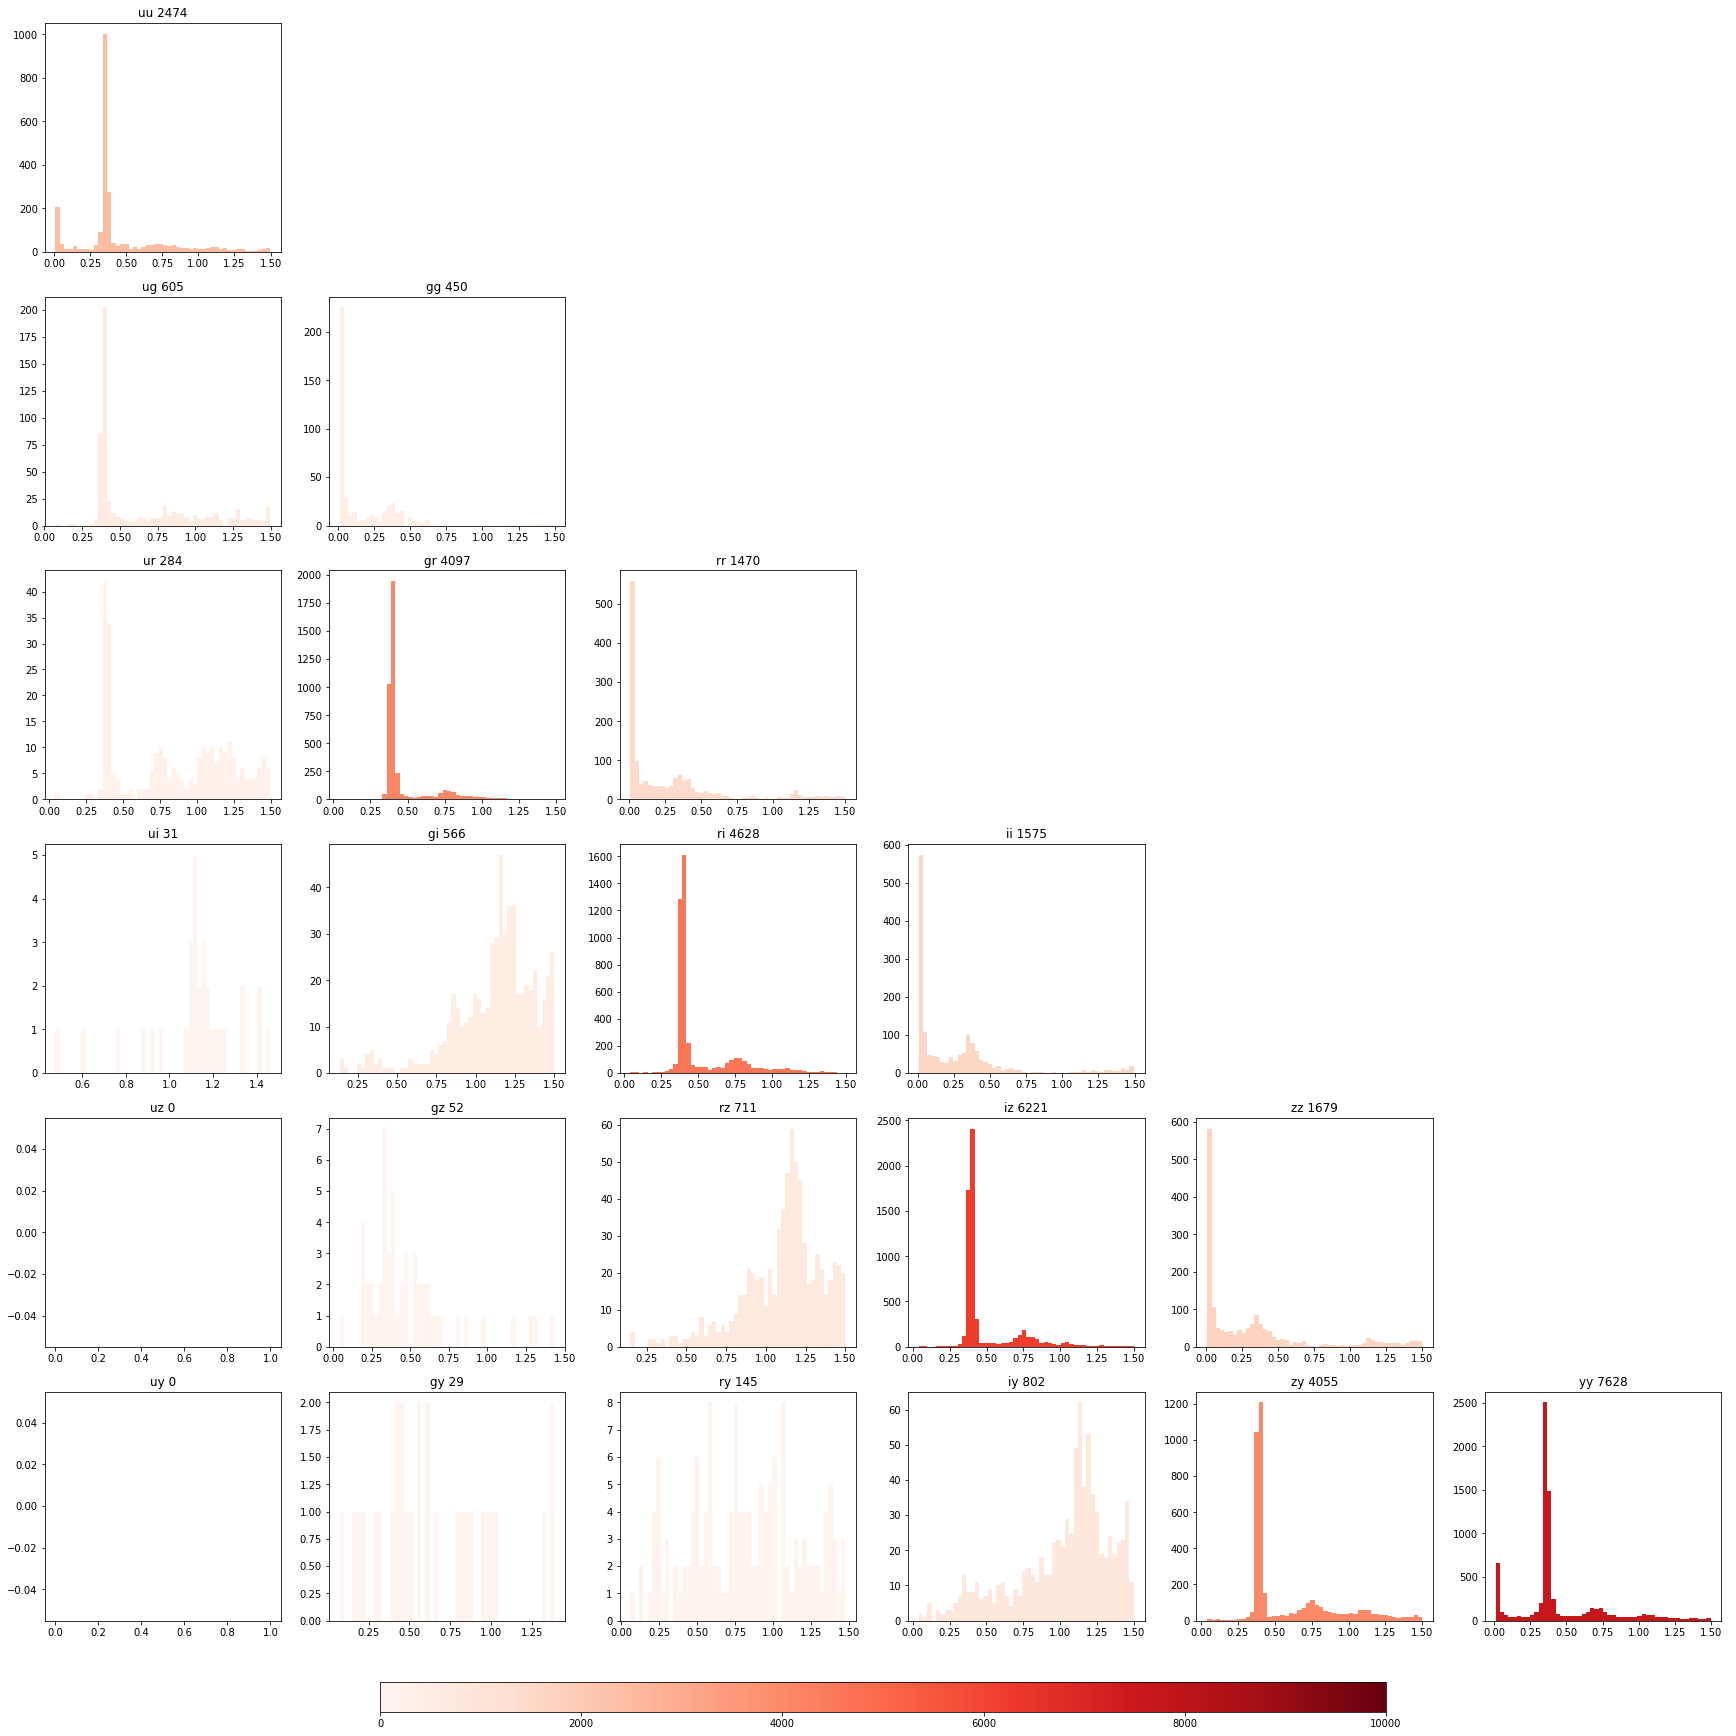

In [200]:
%%time

plot_hist_triangle_all(filename='data/tFilter_baseline_v1.4_10yrs.db_nside8_noDD.csv')

loaded  data/tFilter_baseline_v1.4_10yrs.db_nside8_noDD.csv
CPU times: user 14.4 s, sys: 3.88 s, total: 18.2 s
Wall time: 13.6 s


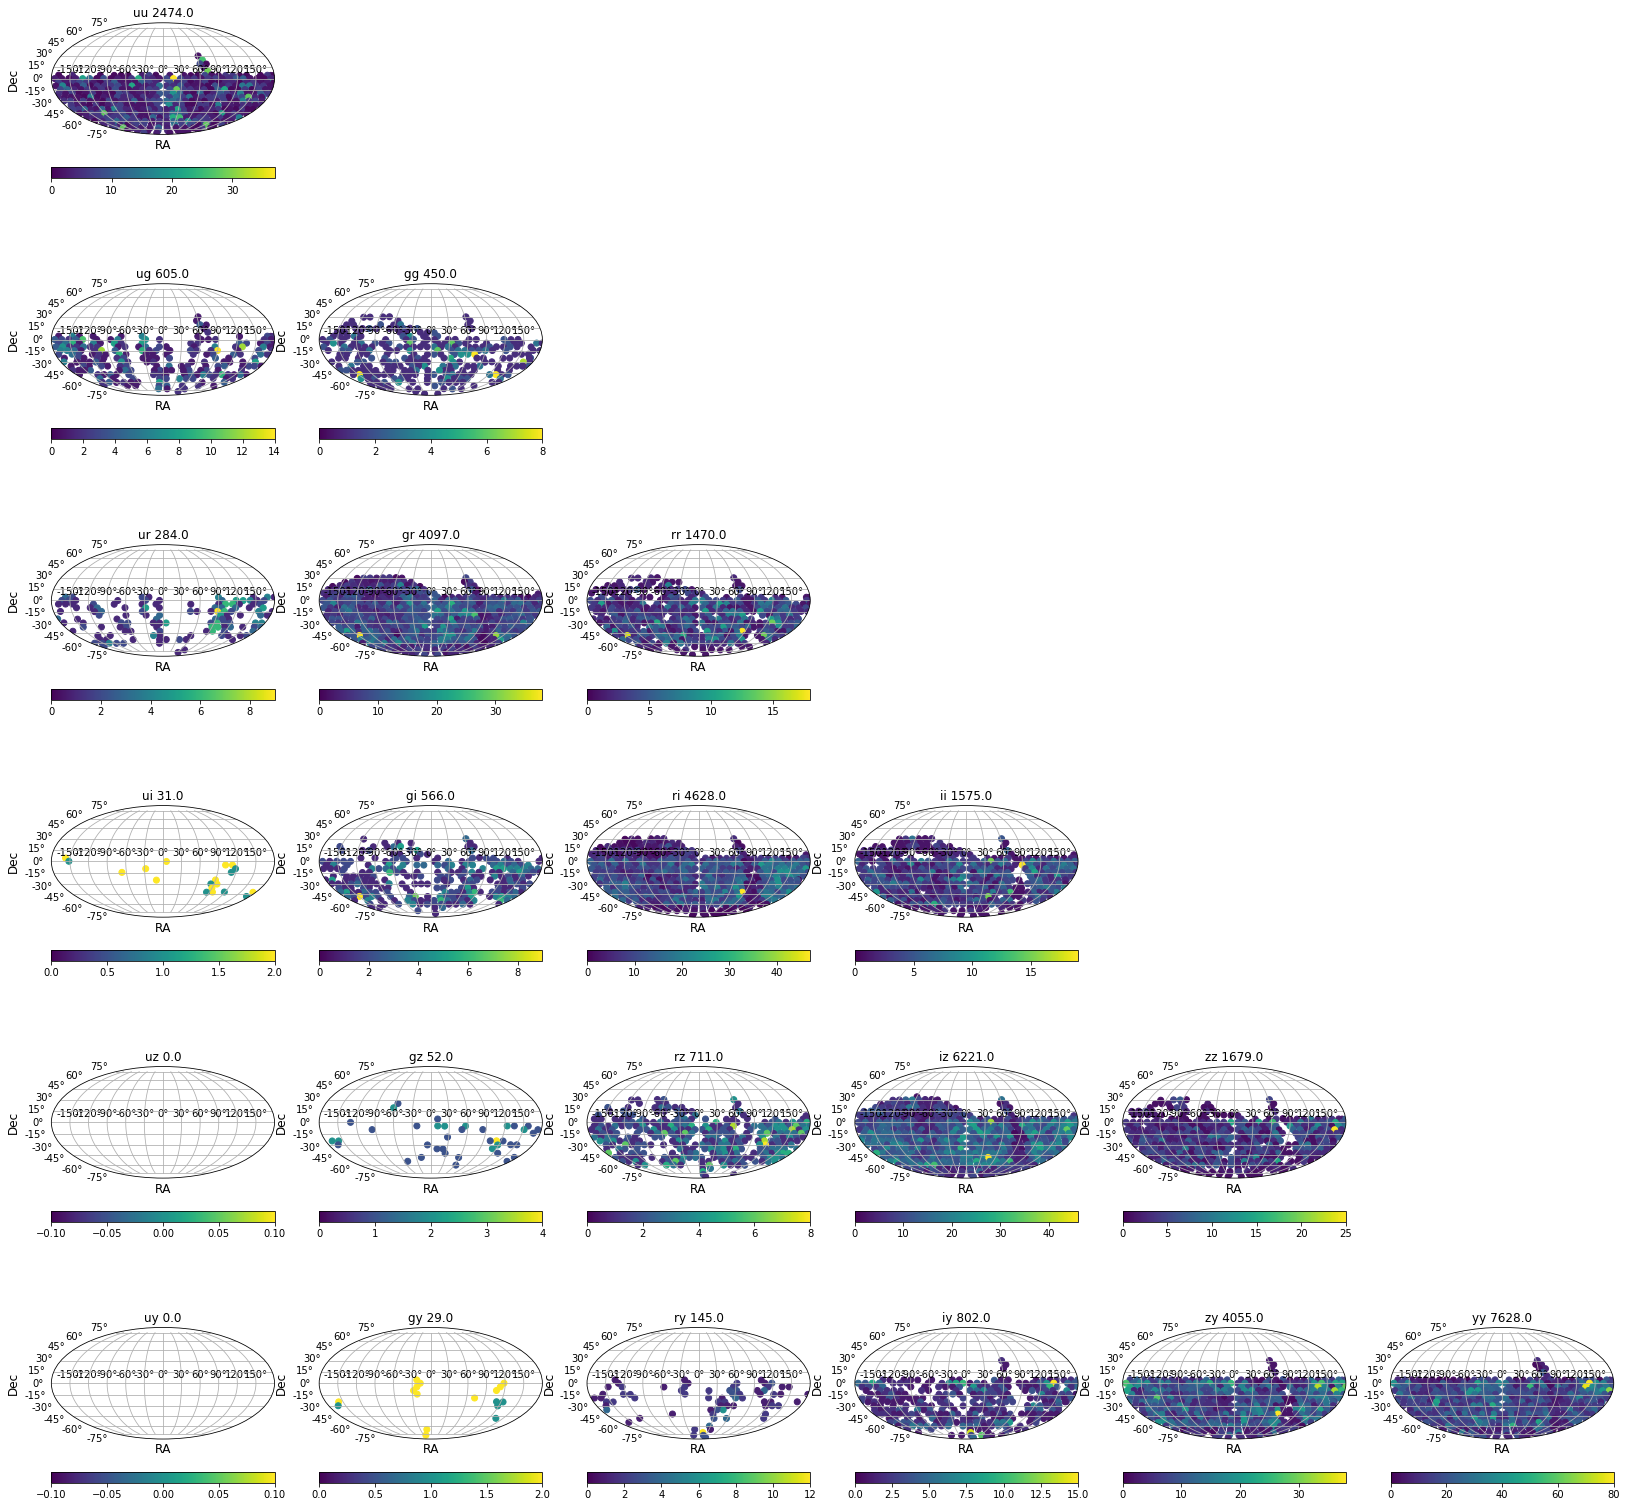

In [206]:
%%time

plot_skymaps(filename='data/tFilter_baseline_v1.4_10yrs.db_nside8_noDD.csv')


loaded  data/tFilter_baseline_v1.4_10yrs.db_nside16_noDD.csv
CPU times: user 44.2 s, sys: 148 ms, total: 44.3 s
Wall time: 44.2 s


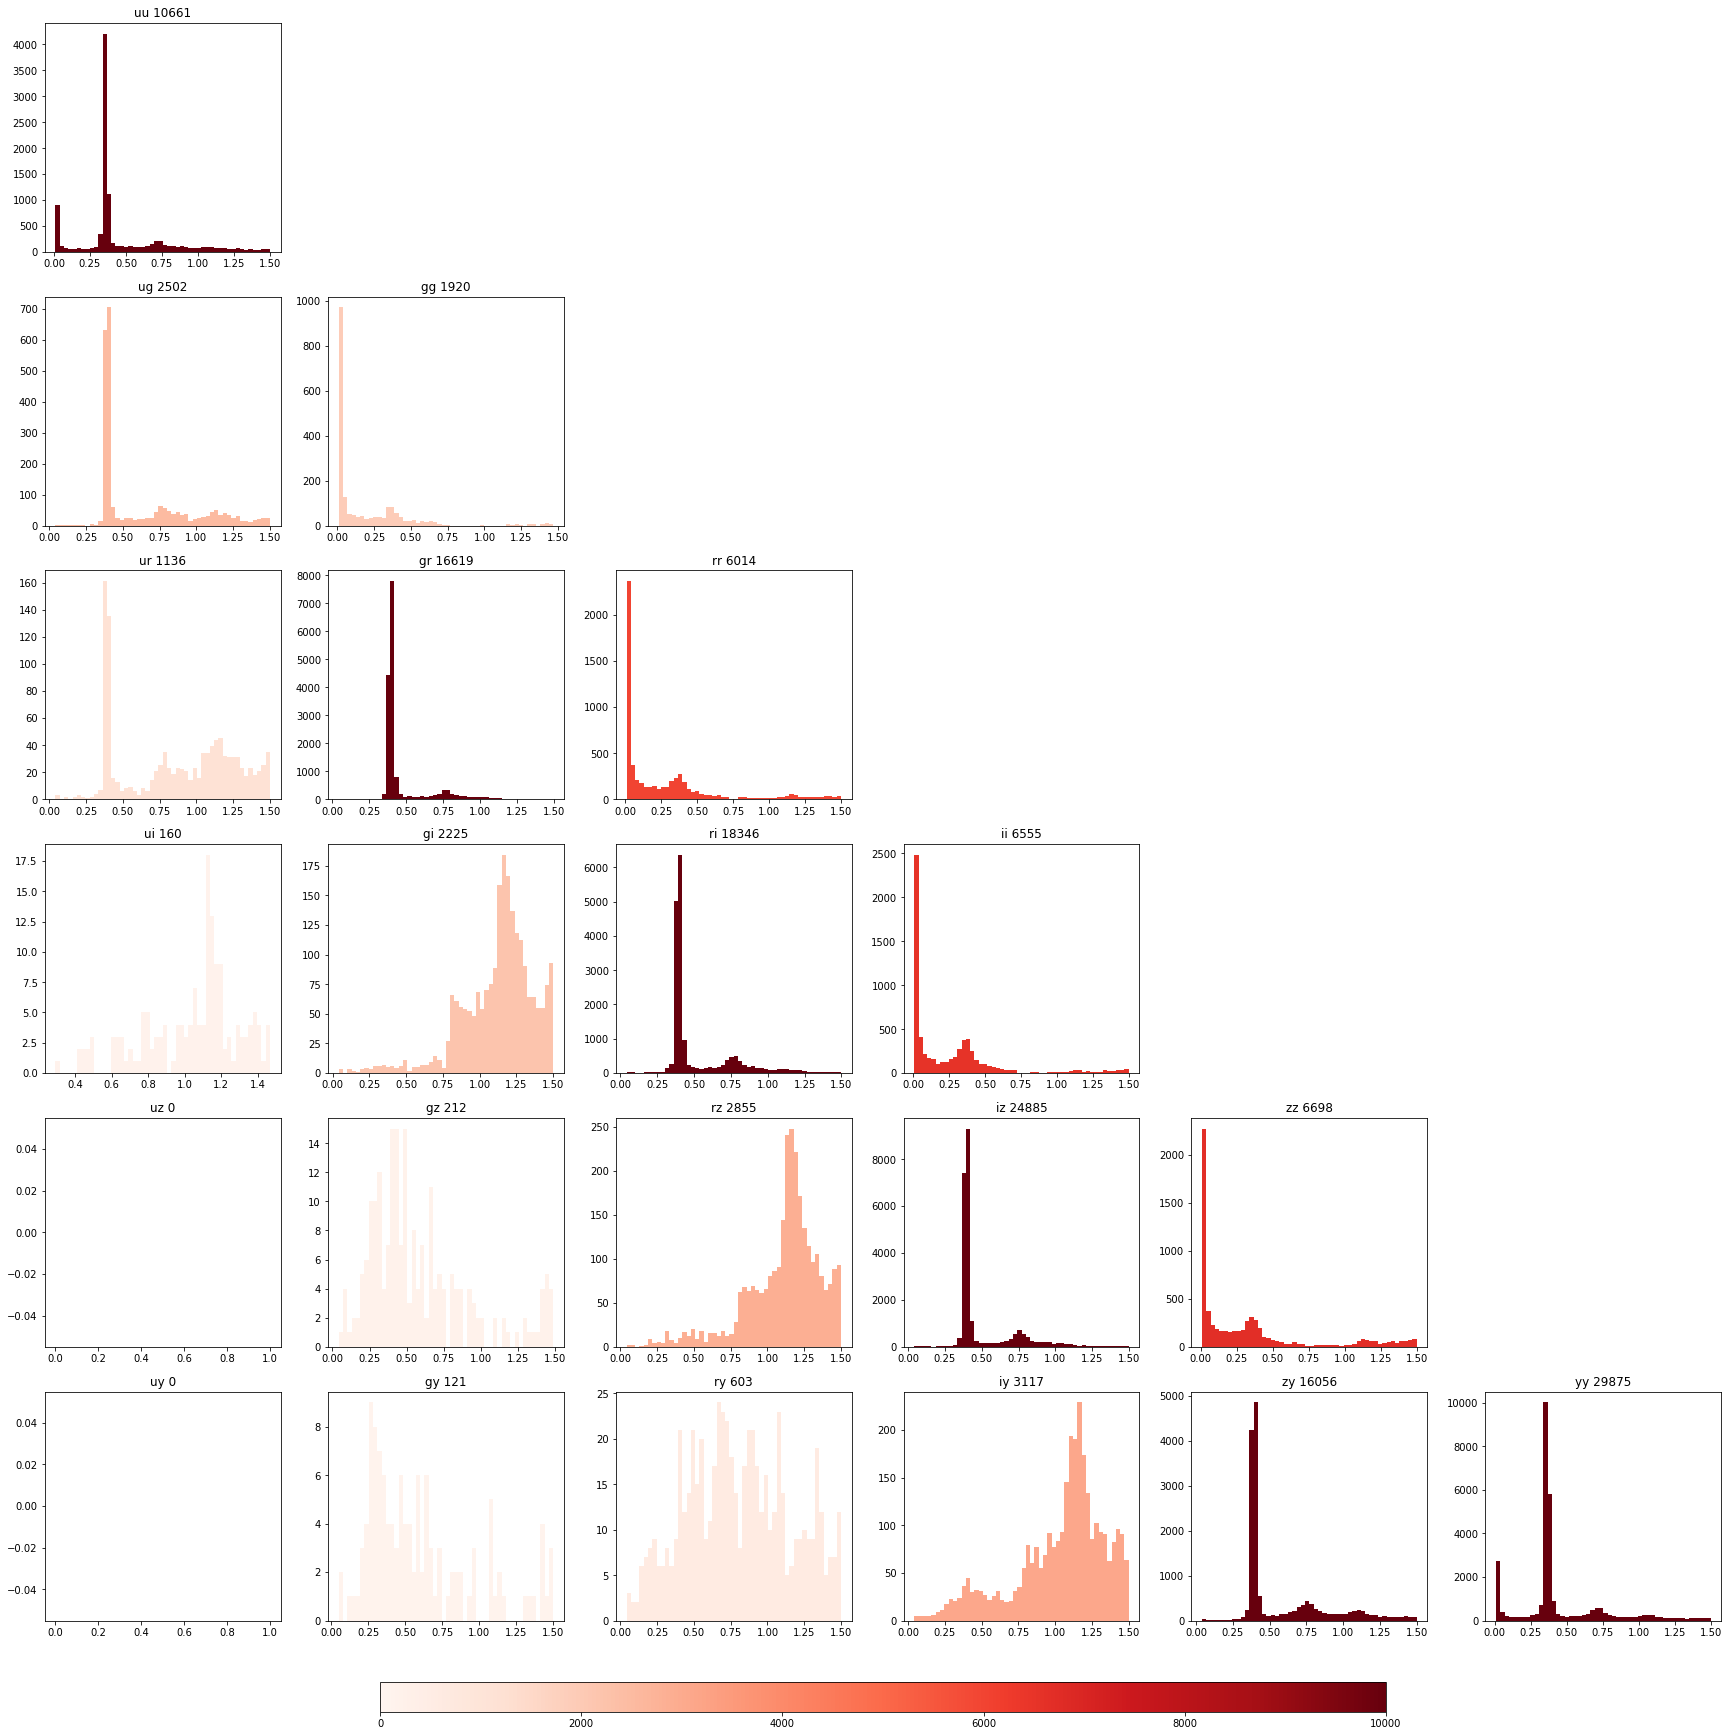

In [211]:
%%time

plot_hist_triangle_all(filename='data/tFilter_baseline_v1.4_10yrs.db_nside16_noDD.csv', vmax=30000)

---

get data from opsim without healpix

In [ ]:
class getDataMetric(metrics.BaseMetric):
    """
    returns required data 
    """
    
    def __init__(self, colname=['airmass', 'expMJD'], dataout=True, returnIdx=1, **kwargs):
        self.colname = colname
        self.returnIdx = returnIdx
        self.dataout = dataout
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
        
        
    def run(self, dataSlice, slicePoint=None):
        
        # return dataSlice directly
        if self.dataout:
            result = dataSlice
            return result
        else:
            result = np.mean(dataSlice[self.colname[int(self.returnIdx)]])
            return float(result)


In [ ]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.4/"  # path to all opsim databases

# output directory
outDir = 'outDir'
resultsDb = db.ResultsDb(outDir=outDir)

In [ ]:
dbname = "baseline_v1.4_10yrs.db"  # name of opsim database
opsdb = db.OpsimDatabase(dbpath+dbname)


In [ ]:
metric = getDataMetric(colname=['night', 'observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter', 'note'])
slicer = slicers.UniSlicer()
#slicer = slicers.HealpixSlicer(nside=16)
sqlconstraint = 'night<400'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)
